In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.fftpack import fft, fftfreq
import pandas as pd
import numpy as np
from uncertainties import ufloat
from uncertainties.umath import *
import uncertainties.unumpy as unumpy
from scipy.special import jv
from scipy.interpolate import Rbf
from scipy.optimize import fmin, minimize, curve_fit
import cmath

In [2]:
# Constants of the physical system
r_outer = 0.5*ufloat(20.6, 0.005)
r_inner = ufloat(2.5, 0.05)
x = r_outer - r_inner
i = cmath.sqrt(-1)  

# Magnitude and argument of Bessel function
M = lambda x : np.abs(jv(0,x))
Phi = lambda x : np.angle(jv(0,x))


# Data files
args = [('TW-60_1.csv',60),('TW-60_2.csv',60),('TW-120_1.csv',120),('TW-120_2.csv',120),('TW-240_2.csv',240), ('TW-480_1.csv',480)]



In [3]:
def in_wave(T):
    '''
    Generate 4 cycles of the incoming squarewave of period T, starting at T=100
    '''
    n = 5*T
    wave = [100]*n+[0]*n+[100]*n+[0]*n+[100]*n+[0]*n+[100]*n+[0]*n
    return wave



In [4]:
def make_fig(D, labs, method):
    '''
    Generates a plot comparing the different values of D
    '''
    nv = np.array([x.nominal_value for x in  D])
    err = np.array([x.std_dev for x in D])
    lu = {x[1]:x[0]+1 for x in enumerate(sorted(set(labs)))}
    
    fig = plt.figure()
    ax = fig.add_axes([0.25,0.1,0.5,0.8])
    
    ax.set_xlim(np.min(nv-err)-0.1*np.abs(np.min(nv-err)), np.max(nv+err)*1.1)
    ax.set_ylim(0, len(set(labs))+1)
    
    if type(method) is type(str('')):
        ax.set_title(method)
        for n,s,l in zip(nv,err,labs):
            ax.errorbar(n, lu[l], xerr = s, markersize='10',capsize=8, elinewidth=2)
    else:
        cc = mpl.rcParams['axes.color_cycle']
        color = {x[1]:cc[x[0]] for x in enumerate(sorted(set(method)))}
        m_old = ''
        for n,s,l,m in zip(nv,err,labs,method):
            ax.errorbar(n, lu[l], xerr = s, markersize='10',capsize=8, elinewidth=2, color=color[m], label='' if m==m_old else m)
            m_old = m
        plt.legend(bbox_to_anchor=(1.1, 0.95),
           bbox_transform=plt.gcf().transFigure)
    
    x_bar = np.mean(nv)
    se = np.std(nv, ddof=1)/np.sqrt(len(nv))

    ax.axvline(x_bar)
    ax.fill_between([x_bar-se, x_bar+se], 0, len(D)+1, facecolor='yellow', alpha=0.5)
    ax.set_yticklabels(sorted(set(labs)))
    ax.set_yticks(range(1,len(set(labs))+1))
    
    ax.set_xlabel("Thermal diffusivity D $(\mathrm{mm}^2/s)$")
    ax.set_ylabel("Period (S)")
    plt.figtext(0.45, 0.15,u"D = %.3f ± %.3f" %(x_bar,se))
    return fig

In [5]:
def prep_data_csv(csv, period):
    '''
    Loads the data, FTs it, picks out the fundenmental, estimates errot.
    Creates incoming wave of same period as the fundemental of the data, FTs it
    '''
    
    
    #Load the data and FT it
    data = pd.read_csv(csv)
    t = np.array(data[data.columns[1]])[0:-1]
    t_err = np.mean(np.array(data[data.columns[2]])[0:-1]/t)
    return(FT_data(t, t_err, period))

def prep_data(csv, period):
    '''
    Loads the data, FTs it, picks out the fundenmental, estimates errot.
    Creates incoming wave of same period as the fundemental of the data, FTs it
    '''
    
    data = pd.read_csv(csv)
    t = np.array(data[data.columns[1]])[0:-1]
    
    if period == 60:
        X = np.arange(0,len(t))*0.1
        rbf = Rbf(X,t, smooth=0.00001)
        
        def f(x, A, omega, phi, a,b,c,d,e):
            p = np.poly1d([ a,b,c,d,e])
            return(p(x)+A*np.sin(omega*x+phi))

        opt,optcov = curve_fit(f, X, rbf(X), p0=[1,2*np.pi/60, 0.1, 1,1,1,1,1])
        t = rbf(X) - np.poly1d(opt[-5:])(X)+opt[-1]
        t_err = 0.5
        return(FT_data(t, t_err, period))

    else:
        #Load the data and FT it
        X = np.arange(0,len(t))*0.1
        t_err = 0.5
        return(FT_data(t, t_err, period))


def FT_data(t,t_err,period):    
    N = len(t)
    T = 2.0*fft(t)/N
    f = fftfreq(len(T),0.1)
    
    # Read error from graph width
    t_err = np.mean(0.5/t)
    T_err = T*t_err


    # Figure out which is the fundemental by comparing to the *known* period
    fund_idx = np.argmin((f - 1./period)**2)
    print "Taking fundemental as %fs" %(1./f[fund_idx])


    # Generate a square wave of the same frequency
    s = in_wave(1./f[fund_idx])
    
    # FT the squarewave
    S = 2.0*fft(s[:N])/N
    
    return (T, T_err, S, f, fund_idx)


In [6]:
###
### Plane Slab Method
###
def D_tf(csv, period):
    '''
    Estimates D from transmission factor using plane slab model
    '''
    (T, T_err, S, f, fund_idx) = prep_data(csv, period)
    
    # TODO error on exterrior T
    A_in = ufloat(np.abs(T[fund_idx]),np.abs( T_err[fund_idx]))
    A_out = ufloat(np.abs(S[fund_idx]), 0.05)

    tf = A_in/A_out
    x = (0.5*ufloat(20.6, 0.005) - ufloat(2.5, 0.05))


    return(np.pi*f[fund_idx]*x**2/log(tf)**2)


def D_phi(csv, period):
    '''
    Estimates D from phase difference using plane slab model
    '''
        
    (T, T_err, S, f, fund_idx) = prep_data(csv, period)
    
    phi_in = ufloat(np.angle(T[fund_idx]), abs(T_err[fund_idx]*np.angle(T[fund_idx])))
    phi_out = np.angle(S[fund_idx])
    delta_phi = phi_in - phi_out
    x = (0.5*ufloat(20.6, 0.005) - ufloat(2.5, 0.05))

    return(np.pi*f[fund_idx]*x**2/delta_phi**2)

In [7]:
###
### Bessel Function Method
###
def D_tf_bessel(csv, period):
    '''
    Estimates D from phase difference using Bessel functions
    Inverts the Bessel functions by numerically optimising the sqaured error

    '''
    (T, T_err, S, f, fund_idx) = prep_data(csv, period)
   
    A_in = ufloat(np.abs(T[fund_idx]), np.abs(T_err[fund_idx]))
    A_out = np.abs(S[fund_idx])

    tf = A_in/A_out
    omega = 2*np.pi*f[fund_idx]

    def obj(D, tf):
        x_in = np.sqrt(i*omega/D)*r_inner.n
        x_out = np.sqrt(i*omega/D)*r_outer.n
        return (M(x_in)/M(x_out) - tf)**2
    
    opt = minimize(obj, [0.1], args = (tf.n), bounds = [(1e-5, 1)])
    opt_err = minimize(obj, [0.1], args = (tf.n+tf.s), bounds = [(1e-5, 1)])

    return ufloat(opt.x[0], np.abs(opt.x[0]-opt_err.x[0]))


def D_phi_bessel(csv, period):
    
    '''
    Estimates D from phase difference using Bessel functions
    Inverts the Bessel functions using a lookup table.
    This is different to D_tf_bessel as the Bessel phase function is
    discontinuous due to phase unwrapping

    '''
    (T, T_err, S, f, fund_idx) = prep_data(csv, period)
    
    phi_in = ufloat(np.angle(T[fund_idx]), np.abs(T_err[fund_idx]*np.angle(T[fund_idx])))
    phi_out = np.angle(S[fund_idx])
    delta_phi = phi_in - phi_out
    
    omega = 2*np.pi*f[fund_idx]
    
    x = X[np.argmin((LU - delta_phi.n)**2)]
    x_err = np.abs(X[np.argmin((LU - (delta_phi.n+delta_phi.s))**2)] - x)
    x = ufloat(x, x_err)
    
    return (omega*r_inner**2) /(x**2)


def make_lookup(N):
    '''
    Makes a lookup table of Phi(sqrt(i)x). This is neccesary so we can run 
    np.unwrap on the raw function output before using it to solve for D.
    
    The lookup table gives an accuracy of ±0.00001
    '''
    alpha = (r_outer/r_inner).nominal_value
    
    def f(x):
        return Phi(np.sqrt(i)*x)- Phi(alpha*np.sqrt(i)*x)
    X = np.arange(0, 4, 1./N)    
    Y = np.unwrap([f(v) for v in X])
    return X,Y  

N = 1e5
X,LU = make_lookup(N)
def lookup(x, N):
    ndp = np.floor(np.log10(N))
    idx = int(np.round(x,decimals = int(ndp))*10**ndp)
    return LU[idx]

In [8]:
###
### Physical Method
###

period = unumpy.uarray([60.68,58.25,60.68,119.76,120.00,239.48,479.47],[1.2,1.2,1.2,1.9,2.3,5.0,10])
A_in = unumpy.uarray([0.93,0.92,0.88,3.11,4.12,13.92,29.88], [0.02,0.02,0.02,0.05,0.06,0.20,0.46])
phi_in = unumpy.uarray([0.75,1.31,1.26,2.48,2.33,1.02,0.52], [0.80,0.84,0.81,0.64,0.78,0.81,0.81])

A_out = 63.6619817819
phi_out = -1.57014182833

tf = A_in/A_out
x = (0.5*ufloat(20.6, 0.005) - ufloat(2.5, 0.05))
D_tf_physical = np.pi*x**2/(period*unumpy.log(tf)**2)

delta_phi = phi_in - phi_out
D_phi_physical = np.pi*x**2/(period*delta_phi**2)

Taking fundemental as 60.000000s
Taking fundemental as 60.000000s
Taking fundemental as 123.200000s
Taking fundemental as 139.766667s
Taking fundemental as 240.000000s
Taking fundemental as 479.975000s
Taking fundemental as 123.200000s
Taking fundemental as 139.766667s
Taking fundemental as 240.000000s
Taking fundemental as 479.975000s
Taking fundemental as 60.000000s
Taking fundemental as 60.000000s
Taking fundemental as 123.200000s
Taking fundemental as 139.766667s
Taking fundemental as 240.000000s
Taking fundemental as 479.975000s
Taking fundemental as 123.200000s
Taking fundemental as 139.766667s
Taking fundemental as 240.000000s
Taking fundemental as 479.975000s
Taking fundemental as 60.000000s
Taking fundemental as 60.000000s
Taking fundemental as 123.200000s
Taking fundemental as 139.766667s
Taking fundemental as 240.000000s
Taking fundemental as 479.975000s
Taking fundemental as 123.200000s
Taking fundemental as 139.766667s
Taking fundemental as 240.000000s
Taking fundemental a

/Library/Python/2.7/site-packages/ipykernel/__main__.py:6: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


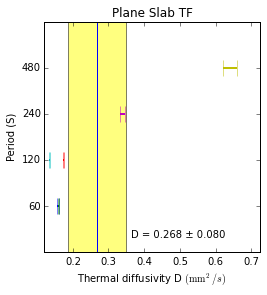

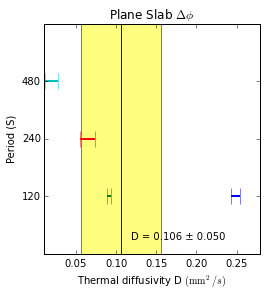

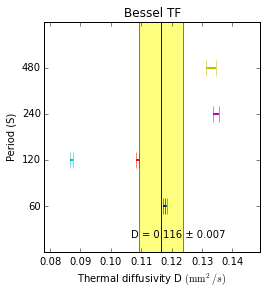

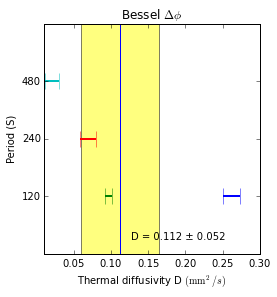

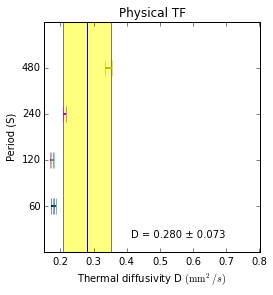

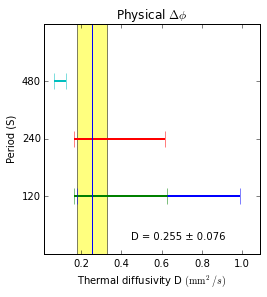

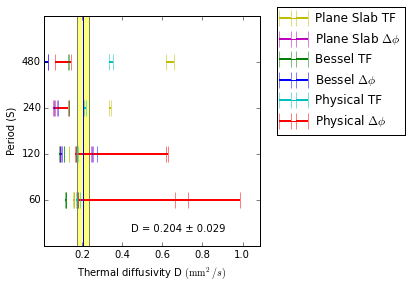

In [9]:

make_fig([D_tf(a[0], a[1]) for a in args], [a[1] for a in args],'Plane Slab TF').savefig("planeslab_tf.pdf")  
make_fig([D_phi(a[0], a[1]) for a in args[2:]], [a[1] for a in args[2:]], 'Plane Slab $\Delta\phi$').savefig("planeslab_phi.pdf")  
make_fig([D_tf_bessel(a[0], a[1]) for a in args], [a[1] for a in args], 'Bessel TF').savefig("bessel_tf.pdf")  
make_fig([D_phi_bessel(a[0], a[1]) for a in args[2:]], [a[1] for a in args[2:]], 'Bessel $\Delta\phi$').savefig("bessel_phi.pdf")  
make_fig(D_tf_physical, [a[1] for a in args],'Physical TF').savefig("physical_tf.pdf")  
make_fig(D_phi_physical, [a[1] for a in args[2:]],'Physical $\Delta\phi$').savefig("physical_phi.pdf")  



combined_D = [D_tf(a[0], a[1]) for a in args]+[D_phi(a[0], a[1]) for a in args[2:]]+[D_tf_bessel(a[0], a[1]) for a in args]+[D_phi_bessel(a[0], a[1]) for a in args[2:]]+list(D_tf_physical)+list(D_phi_physical)
combined_T = [a[1] for a in args]+[a[1] for a in args[2:]]+[a[1] for a in args]+[a[1] for a in args[2:]]+[a[1] for a in args]+[a[1] for a in args]
combined_method = ['Plane Slab TF']*6+[ 'Plane Slab $\Delta\phi$']*4+['Bessel TF']*6+['Bessel $\Delta\phi$']*4+['Physical TF']*6+['Physical $\Delta\phi$']*6
make_fig(combined_D, combined_T, combined_method).savefig("combined.pdf")

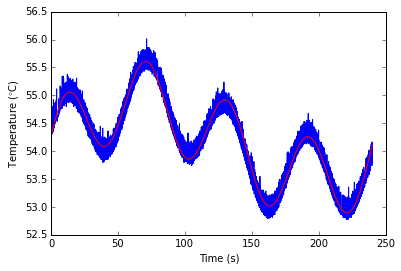

In [10]:
#Load the data and FT it
data = pd.read_csv(args[1][0])
T = np.array(data[data.columns[1]])[0:-1]
N = len(T)
X = np.arange(0,N)*0.1
from scipy.interpolate import Rbf
rbf = Rbf(X,T, smooth=0.00001)

plt.plot(X, T,'b')
#plt.plot(X, rbf(X), 'r')

def f(t, A, omega, phi, a,b,c,d,e):
    p = np.poly1d([ a,b,c,d,e])
    return(p(t)+A*np.sin(omega*t+phi))

opt,optcov = curve_fit(f, X, rbf(X), p0=[1,2*np.pi/60, 0.1, 1,1,1,1,1])

plt.plot(X, [f(x, *opt) for x in X], 'r')
plt.xlabel("Time (s)")
plt.ylabel("Temperature ($\degree$C)")
plt.savefig("60_2_before.pdf")

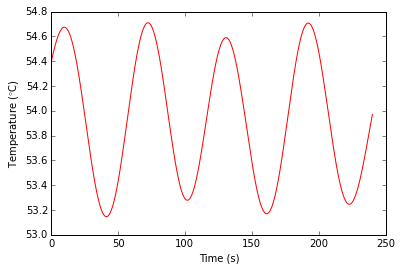

In [11]:
P60s_1_bgrm =  rbf(X)- np.poly1d(opt[3:])(X)+opt[-1]
plt.plot(X, P60s_1_bgrm, 'r') 
plt.xlabel("Time (s)")
plt.ylabel("Temperature ($\degree$C)")
plt.savefig("60_21_after.pdf")